# Imports classiques
Nous allons tout d'abord lancer les imports classiques

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import Optim as opt
import functions as func

Vous devez copier-coller ici votre algorithme de descente de Wolfe ainsi que `ls_wolfe_step_is_one`

In [14]:
def ls_wolfe(x,function,step,descent,f,df) :
    step_min, step_max = 0., np.inf
    scal=np.dot(df,descent)
    step2=step
    e1 = 1e-4
    e2 = 0.9
    continuer = True
    while continuer :
        x2 = step2*descent +x
        f2 = function.value(x2)
        if f2>f+e1*step2*scal : #step is too big, decrease
            step_max=step2
            step2=0.5*(step_min+step_max)
        else:
            df2 = function.grad(x2)
            if np.dot(df2,descent) < e2*scal: #step is too small
                step_min=step2
                if step_max==np.inf :
                    step2=2*step_min
                else :
                    step2=min(0.5*(step_min+step_max),2*step_min)
            else :
                continuer = False
    return x2,f2,df2,step2
            
def ls_wolfe_step_is_one(x,function,step,descent,f,df) :
    return ls_wolfe(x,function,1.,descent,f,df)

## L-BFGS
Nous allons nous intéresser à l'algorithme Limited Memory BFGS. Cet algorithme est du type BFGS, c'est à dire qu'il estime l'inverse de la Hessienne de $f$. Le L dans le nom de l'algorithme signifie qu'il est à mémoire limitée, c'est à dire qu'il ne garde en mémoire que les $L$ dernières itérations de calcul pour estimer la Hessienne.
L'algorithme est le suivant : Nous sommes à l'itération $k$, nous notons $x_k$ l'itéré et nous avons stocké les vecteurs suivants pour tout $k_{min}\le i\le k$.
$$ s_i=x_{i}-x_{i-1} \text{ et } y_i=\nabla f(x_{i}) -\nabla f(x_{i-1})$$
Et on a aussi stocké $\rho_i=\frac{1}{(s_i,y_i)}$. Tous les $\rho_i$ doivent être positifs.
L'algorithme est le suivant 

<div style="background-color:rgba(0, 0, 0, 0.0470588); padding:10px 0;font-family:monospace;">

$r=-\nabla f(x_k)$<br>
Pour $i=k,k-1,\dots k_{min}$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$\alpha_i=\rho_i(s_i \cdot r)$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$r=r-\alpha_i y_i$<br>
$r=\displaystyle \frac{(s_{k_{min}}\cdot y_{k_{min}})}{(y_{k_{min}}\cdot y_{k_{min}})}r$<br>
Pour $i=k_{min},k_{min}+1,\dots,k$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$\beta_i=\rho_i(y_i\cdot r)$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$r=r+(\alpha_i-\beta_i)s_i$<br>
rend r
</div>





# Fonctions sur les listes
Vous aurez sans doute besoin des fonctions suivantes pour les listes

In [6]:
a=[(2*i,3*i) for i in range(5) ]
print(a)
print(a[3],a[-1])
print('*** Pop ***')
a.pop(0)
print(a)
print('*** Parcours ***')
for e,f in a :
      print(e,'et',f)
print('*** Parcours Inverse***')
for e in reversed(a) :
      print(e)
b=[e**2 for e,f in a]
print(b)
print('*** Parcours de deux listes ensembles***')
for (m,(t,p)) in zip(b,a) :
    print(m,'et',t,'et encore',p)
print('*** Append ***')
print(b)
b.append(546)
print(b)
print('*** Inversion ***')
c=list(reversed(b))
print(c)
print(len(b))

[(0, 0), (2, 3), (4, 6), (6, 9), (8, 12)]
(6, 9) (8, 12)
*** Pop ***
[(2, 3), (4, 6), (6, 9), (8, 12)]
*** Parcours ***
2 et 3
4 et 6
6 et 9
8 et 12
*** Parcours Inverse***
(8, 12)
(6, 9)
(4, 6)
(2, 3)
[4, 16, 36, 64]
*** Parcours de deux listes ensembles***
4 et 2 et encore 3
16 et 4 et encore 6
36 et 6 et encore 9
64 et 8 et encore 12
*** Append ***
[4, 16, 36, 64]
[4, 16, 36, 64, 546]
*** Inversion ***
[546, 64, 36, 16, 4]
5


# Class BFGS
Créez une classe `BFGS` ci dessous, sa fonction `__init__` sera de la forme 
`__init__(self,nb_stock_max=8)` où `nb_stock_max` est le nombre maximum d'itérations prises en compte. Cette fonction créera aussi une liste vide appelée `stock` qui conserve les $s_i,g_i,\rho_i$. Elle devra aussi créer une liste vide nommée `last_iter`.

In [18]:
class BFGS() :
    def __init__(self,nb_stock_max=8,verbose=True) :
        self.nb_stock_max = nb_stock_max
        self.stock = []
        self.last_iter = None
        self.verbose = verbose
    def push(self, x, grad):
        if self.last_iter is None :
            self.last_iter = [x, grad]
        else :
            sigmak = x-self.last_iter[0]
            yk = grad-self.last_iter[1]
            rhok = 1/np.dot(sigmak,yk)
            if rhok > 0 :
                while (len(self.stock) >= self.nb_stock_max) :
                    self.stock.pop(0)
                self.stock.append((sigmak, yk, rhok)) 
            else :
                self.stock = []
            self.last_iter = [x,grad]
    def dc(self,x,function,df) :
        self.push(x, df)
        return(self.get(df))
    def get(self, grad) :
        if len(self.stock) == 0 :
            return -grad
        else :
            q = -grad
            La = []
            for (s,y,r) in reversed(self.stock) :
                a = r*np.dot(s,q)
                La.append(a)
                q = q - a*y
            La.reverse()
            s0, y0, r0 = self.stock[0]
            q = np.dot(s0,y0)/np.dot(y0,y0) * q
            for ((s,y,r),a) in zip(self.stock, La) :
                B = r*np.dot(y,q)
                q = q + (a - B)*s
            return q


# Push
Nous allons maintenant créer une fonction `push(self, x, grad)` qui enregistre $s_k,g_k,\rho_k$. Pour cela, on a besoin de $x_{k-1},\nabla f(x_{k-1})$. Si ils existent, ils se trouvent dans la liste `self.last_iter`. Ensuite on peut calculer $s_k,g_k$ et $\rho_k$. 

Si $\rho_k$ est positif, alors on enregistre le triplet $(s_k,g_k,\rho_k)$ à la fin de la liste `self.stock`, en vérifiant `self.stock` ne doit contenir au maximum que les dernières `self.nb_stock_max` itérations (si nécessaire on retire le tout premier élément de `self.stock`). 

Si $\rho_k$ est négatif, quelquechose c'est mal passé, on vide le `self.stock`.

A la fin, on n'oublie pas de mettre $x_{k}$ et $\nabla f(x_{k})$ dans `self.last_iter` pour être sûr de les y trouver la prochaine fois.

# Get

Nous allons maintenant créer une fonction `get(self, grad)` qui modifie la direction de descente et applique l'algorithme ci-dessus. Cette fonction doit nous rendre le `r` final. Si le `self.stock` est vide, cette fonction doit nous rendre `-grad`

# dc

Nous créeons maintenant une fonction `dc(self,x,function,df)` qui appplique tout d'abord `self.push` puis `self.get`, elle rend le résultat de la fonction de `self.get`.

# C'est l'heure de tester ...
Lancez une méthode de Newton_Wolfe sur votre fonction préférée et à chaque itération calculez ce que donnerait un L-BFGS. Comparez les angles des directions entre la méthode de Newton et le L-BFGS, comparez aussi le ration des normes. Ensuite lancez un LBFGS avec recherche de pas de Wolfe sur vos tests préférez et obtenez le comportement de Newton_Wolfe sans le calcul de la Hessienne...

iter=   0 f=-4.030e-02 df=9.589e-01 comp=[   1,   1,   0]
iter=   1 f=-3.876e-01 df=4.552e-01 comp=[   2,   2,   0]
iter=   2 f=-4.787e-01 df=2.055e-01 comp=[   3,   3,   0]
iter=   3 f=-4.990e-01 df=4.415e-02 comp=[   4,   4,   0]
iter=   4 f=-5.000e-01 df=3.843e-03 comp=[   5,   5,   0]
iter=   5 f=-5.000e-01 df=8.867e-05 comp=[   6,   6,   0]
Success !!! Algorithm converged !!!


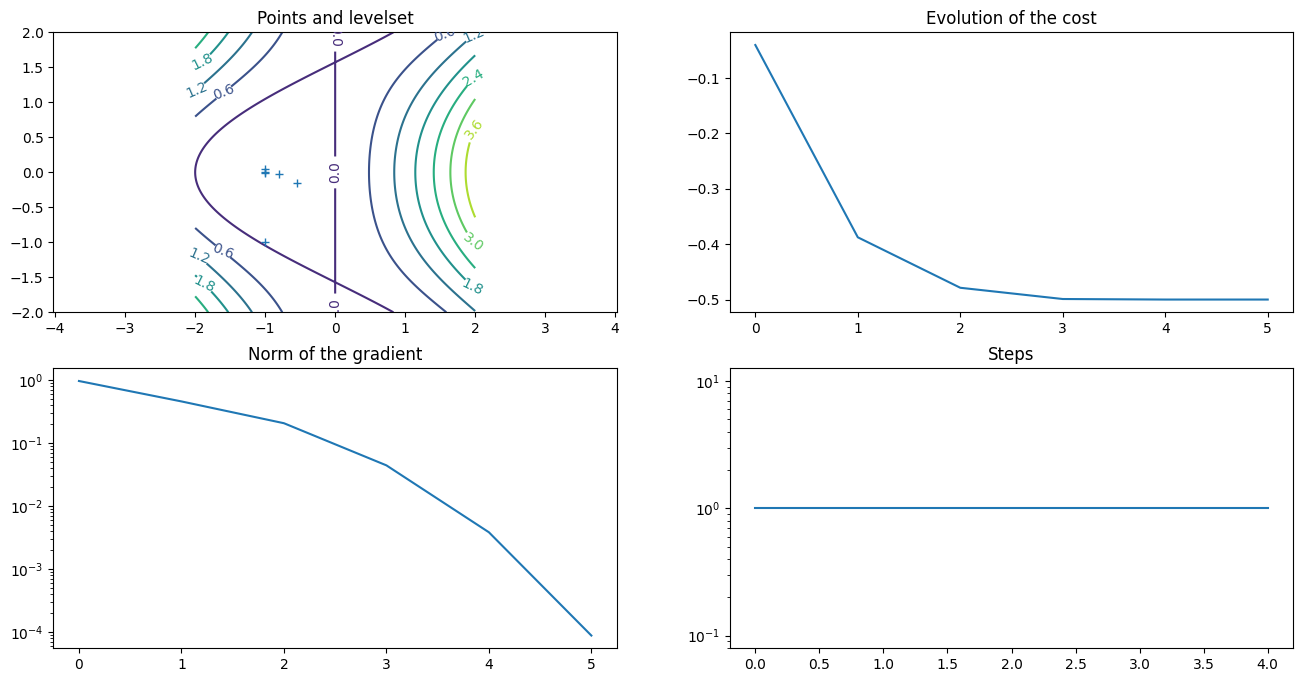

iter :  52 cost :2.882e-13 grad :2.120e-05 comp=[  80,  56,   0]


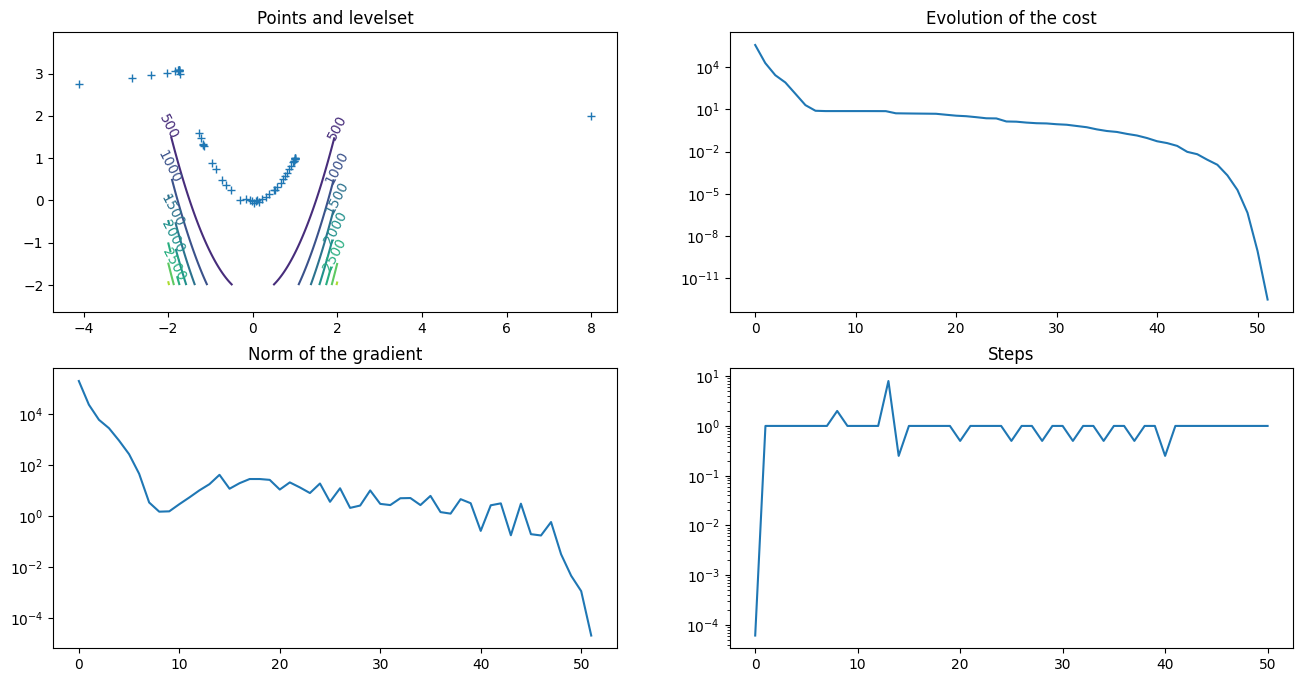

In [19]:
f=func.oscill()
x0=np.array([-1,-1])
B=BFGS()
res=opt.main_algorithm(f,0.1,x0,ls=ls_wolfe_step_is_one,dc=B.dc,verbose=True)
opt.graphical_info(res,f)


f=func.Rosen()
x0=np.array([8,2])
B=BFGS()
res=opt.main_algorithm(f,1,x0,ls=ls_wolfe_step_is_one,dc=B.dc,verbose=False)
print("iter : {:3d} cost :{:1.3e} grad :{:1.3e} comp=[{:4d},{:4d},{:4d}]"
      .format(len(res['list_costs']),res['list_costs'][-1],res['list_grads'][-1],f.nb_eval,f.nb_grad,f.nb_hess))
opt.graphical_info(res,f)

iter :  25 cost :4.379e-11 grad :7.989e-05 comp=[  38,  27,   0]


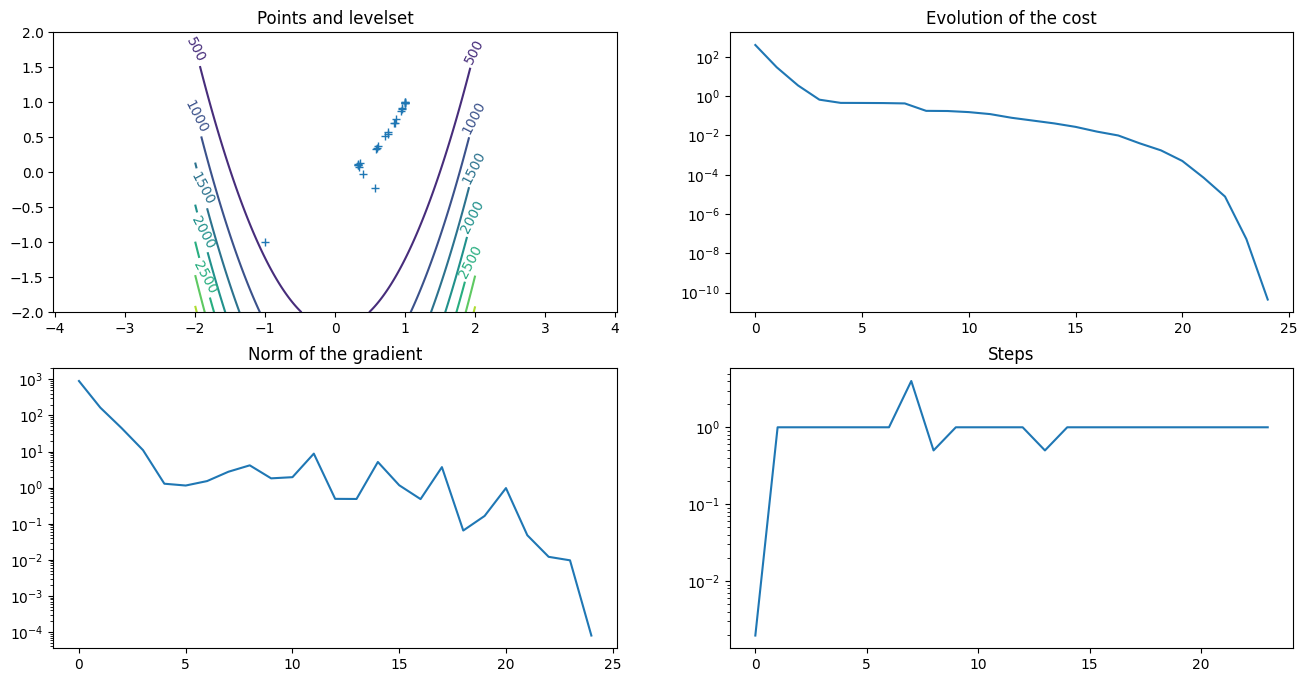

In [26]:
f=func.Rosen()
x0=np.array([-1,-1])
B=BFGS()
res=opt.main_algorithm(f,1,x0,ls=ls_wolfe_step_is_one,dc=B.dc,verbose=False)
print("iter : {:3d} cost :{:1.3e} grad :{:1.3e} comp=[{:4d},{:4d},{:4d}]"
      .format(len(res['list_costs']),res['list_costs'][-1],res['list_grads'][-1],f.nb_eval,f.nb_grad,f.nb_hess))
opt.graphical_info(res,f)

## Comparaison
Votre objectif est de regarder la documentation de `scipy.optimize`, de comprendre le code suivant et de comparer votre algorithme de BFGS+Wolfe avec les algorithmes disponibles dans scipy.optimize

In [24]:
f=func.Rosen()
x0=np.array([-1,-1])
from scipy.optimize import minimize
res=minimize(f.value,x0,jac=f.grad, tol=0.0001)


In [25]:
print(res)
print("----------------")
print(f.nb_eval,f.nb_grad)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 5.65042717850891e-13
        x: [ 1.000e+00  1.000e+00]
      nit: 30
      jac: [-2.660e-05  1.292e-05]
 hess_inv: [[ 5.004e-01  1.000e+00]
            [ 1.000e+00  2.003e+00]]
     nfev: 39
     njev: 39
----------------
39 39
